In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, max, min, to_date, month


In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark

spark = SparkSession.builder \
    .appName("India Air Quality Analysis") \
    .getOrCreate()

spark


In [ ]:
df = spark.read.csv("/content/city_day.csv", header=True, inferSchema=True)
df.show(5)

+---------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+
|     City|  Datetime|PM2.5| PM10|   NO| NO2|  NOx| NH3|  CO| SO2|   O3|Benzene|Toluene|Xylene|  AQI|  AQI_Bucket|
+---------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+
|    Delhi|2015-01-01|153.3|241.7|182.9|33.0| 81.3|38.5|1.87|64.5| 83.6|  18.93|  20.81|  8.32|204.5|      Severe|
|   Mumbai|2015-01-01| 70.5|312.7|195.0|42.0|122.5|31.5|7.22|83.8|108.0|   2.01|  19.41|  2.86| 60.9|Satisfactory|
|  Chennai|2015-01-01|174.1|275.4| 56.2|68.8|230.9|28.5|8.56|60.8| 43.9|  19.07|  10.19|  9.63|486.5|      Severe|
|  Kolkata|2015-01-01|477.2|543.9| 14.1|76.4|225.9|45.6|2.41|42.1|171.1|   9.31|  11.65|  9.39|174.4|   Very Poor|
|Bangalore|2015-01-01|171.6|117.7|123.3|12.4| 61.9|49.7|1.26|79.7|164.3|   6.04|  12.74|  9.59|489.7|        Good|
+---------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum



In [ ]:
# Replace dots or spaces in column names with underscores
df = df.toDF(*[c.replace('.', '_').replace(' ', '_') for c in df.columns])
df.show(5)



+---------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+
|     City|  Datetime|PM2_5| PM10|   NO| NO2|  NOx| NH3|  CO| SO2|   O3|Benzene|Toluene|Xylene|  AQI|  AQI_Bucket|
+---------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+------------+
|    Delhi|2015-01-01|153.3|241.7|182.9|33.0| 81.3|38.5|1.87|64.5| 83.6|  18.93|  20.81|  8.32|204.5|      Severe|
|   Mumbai|2015-01-01| 70.5|312.7|195.0|42.0|122.5|31.5|7.22|83.8|108.0|   2.01|  19.41|  2.86| 60.9|Satisfactory|
|  Chennai|2015-01-01|174.1|275.4| 56.2|68.8|230.9|28.5|8.56|60.8| 43.9|  19.07|  10.19|  9.63|486.5|      Severe|
|  Kolkata|2015-01-01|477.2|543.9| 14.1|76.4|225.9|45.6|2.41|42.1|171.1|   9.31|  11.65|  9.39|174.4|   Very Poor|
|Bangalore|2015-01-01|171.6|117.7|123.3|12.4| 61.9|49.7|1.26|79.7|164.3|   6.04|  12.74|  9.59|489.7|        Good|
+---------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum

missing_values = df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])
missing_values.show()


+----+--------+-----+----+---+---+---+---+---+---+---+-------+-------+------+---+----------+
|City|Datetime|PM2_5|PM10| NO|NO2|NOx|NH3| CO|SO2| O3|Benzene|Toluene|Xylene|AQI|AQI_Bucket|
+----+--------+-----+----+---+---+---+---+---+---+---+-------+-------+------+---+----------+
|   0|       0|    0|   0|  0|  0|  0|  0|  0|  0|  0|      0|      0|     0|  0|         0|
+----+--------+-----+----+---+---+---+---+---+---+---+-------+-------+------+---+----------+



In [ ]:
df = df.withColumn("Datetime", to_date(col("Datetime"), "yyyy-MM-dd"))

In [ ]:
df.groupBy("city") \
  .agg(avg("aqi").alias("avg_aqi")) \
  .orderBy(col("avg_aqi").desc()) \
  .show()


+---------+------------------+
|     city|           avg_aqi|
+---------+------------------+
|   Mumbai|253.31905283328808|
|    Delhi| 251.4963044073368|
|  Kolkata|250.63539556528863|
|  Chennai|250.33876266082618|
|Bangalore|249.76739666027927|
+---------+------------------+



In [ ]:
df = df.withColumn("month", month(col("Datetime")))

monthly_avg = df.groupBy("month") \
                .agg(avg("pm2_5").alias("avg_pm2_5"),
                     avg("pm10").alias("avg_pm10"),
                     avg("no2").alias("avg_no2")) \
                .orderBy("month")

monthly_avg.show()

+-----+------------------+------------------+-----------------+
|month|         avg_pm2_5|          avg_pm10|          avg_no2|
+-----+------------------+------------------+-----------------+
|    1|245.06348387096796|           303.416|74.61806451612915|
|    2| 249.0291166077736| 290.7795053003533|76.03971731448777|
|    3| 253.9121935483871| 293.9144516129039|76.16470967741941|
|    4|250.51580000000035| 307.0853333333332|75.26006666666672|
|    5|256.92238709677366|295.60806451612893|73.74406451612903|
|    6|251.25386666666674| 303.3486666666673|76.26006666666676|
|    7|249.45612903225836|292.45600000000013|74.67825806451629|
|    8| 255.0841935483869| 301.9606451612905| 74.1518709677418|
|    9| 247.1905333333333| 297.4442666666668|76.81453333333324|
|   10|257.36219354838687|304.82877419354827|74.91554838709672|
|   11|245.73886666666687|299.37760000000054|75.00546666666678|
|   12|245.25883870967724| 302.6420645161292|77.44703225806452|
+-----+------------------+--------------

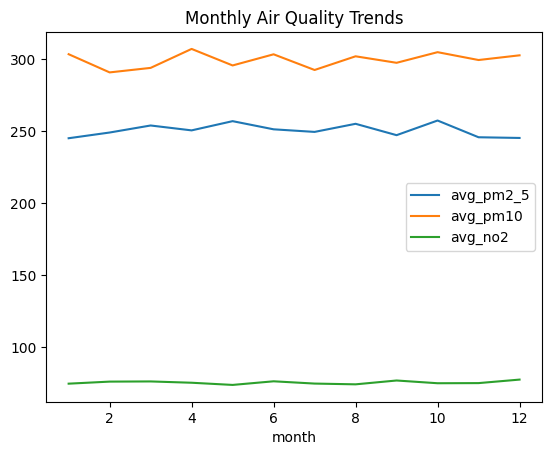

In [ ]:
import matplotlib.pyplot as plt

monthly_avg_pd = monthly_avg.toPandas()
monthly_avg_pd.plot(x="month", y=["avg_pm2_5","avg_pm10","avg_no2"], kind="line")
plt.title("Monthly Air Quality Trends")
plt.show()


+----+------------------+------------------+------------------+
|year|         avg_pm2_5|          avg_pm10|           avg_aqi|
+----+------------------+------------------+------------------+
|2015| 251.2253150684932| 304.3358904109583|247.41802739726054|
|2016|244.71060109289607|301.10256830601037|250.10579234972653|
|2017|251.34043835616433|301.70252054794565|250.88679452054797|
|2018|  249.377698630137|300.92789041095847| 246.3123287671231|
|2019|251.33315068493133| 297.7037260273976|255.42964383561608|
|2020|256.70245901639333| 294.7690710382518| 247.3077595628413|
|2021|252.24252054794508| 296.6395068493156|252.50273972602702|
|2022|255.37813698630092| 299.1078904109586|250.47430136986327|
|2023|248.70515068493143|302.53178082191783|257.00613698630184|
|2024|244.97628415300534|295.62278688524583| 253.6764480874317|
+----+------------------+------------------+------------------+



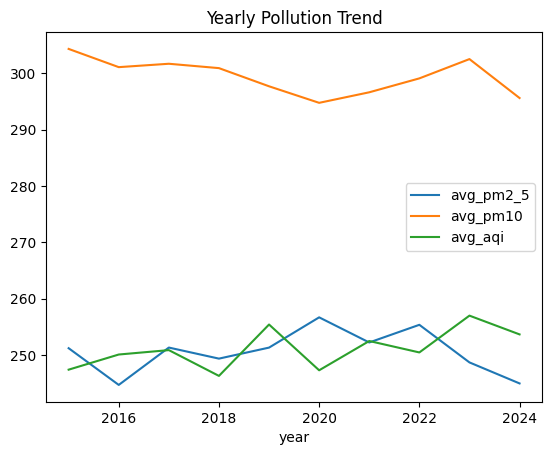

In [ ]:
from pyspark.sql.functions import year

df = df.withColumn("year", year(col("Datetime")))

yearly_avg = df.groupBy("year").agg(
    avg("pm2_5").alias("avg_pm2_5"),
    avg("pm10").alias("avg_pm10"),
    avg("aqi").alias("avg_aqi")
).orderBy("year")

yearly_avg.show()

# Visualization
yearly_avg_pd = yearly_avg.toPandas()
yearly_avg_pd.plot(x="year", y=["avg_pm2_5","avg_pm10","avg_aqi"], kind="line", title="Yearly Pollution Trend")
plt.show()


In [ ]:
for pollutant in ["pm2_5","pm10","no2","so2","co","o3"]:
    top_city = df.groupBy("city") \
                 .agg(avg(col(pollutant)).alias(f"avg_{pollutant}")) \
                 .orderBy(col(f"avg_{pollutant}").desc()) \
                 .limit(5)
    print(f"Top 5 cities for {pollutant.upper()}")
    top_city.show()


Top 5 cities for PM2_5
+---------+------------------+
|     city|         avg_pm2_5|
+---------+------------------+
|    Delhi| 252.9058581987402|
|  Chennai|252.51513824254093|
|  Kolkata|250.45688475225893|
|   Mumbai|248.56375581713652|
|Bangalore| 248.5468382151651|
+---------+------------------+

Top 5 cities for PM10
+---------+------------------+
|     city|          avg_pm10|
+---------+------------------+
|  Kolkata|303.28740761018287|
|   Mumbai| 301.7379687927731|
|  Chennai|297.99033670955345|
|    Delhi|297.42685464002295|
|Bangalore| 296.7698877634812|
+---------+------------------+

Top 5 cities for NO2
+---------+-----------------+
|     city|          avg_no2|
+---------+-----------------+
|    Delhi|75.91147002463713|
|   Mumbai|75.66917601970988|
|  Kolkata|75.32157131125086|
|  Chennai|75.15113605255956|
|Bangalore|75.02622502053093|
+---------+-----------------+

Top 5 cities for SO2
+---------+------------------+
|     city|           avg_so2|
+---------+---------

+------------+------------------+------------------+------------------+
|      season|         avg_pm2_5|          avg_pm10|           avg_aqi|
+------------+------------------+------------------+------------------+
|     Monsoon|250.77116393442608| 298.7762622950808|248.96922950819706|
|Post-Monsoon|251.64580327868842| 302.1478688524591| 249.0431147540978|
|      Summer|253.81897826087038|298.77997826086914|252.61397826086997|
|      Winter|246.37337763012204|299.19003322259147| 253.8718272425254|
+------------+------------------+------------------+------------------+



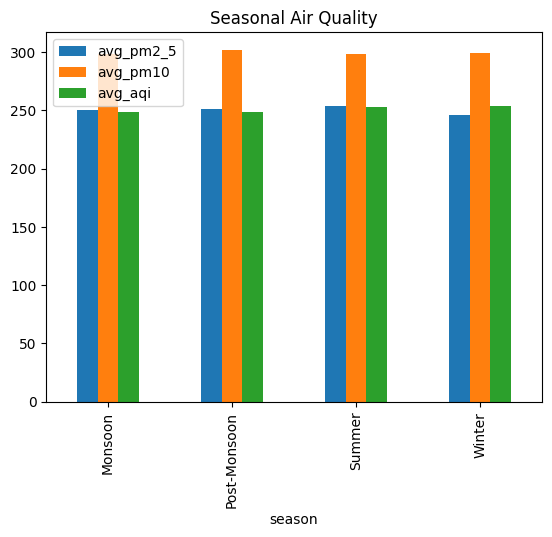

In [ ]:
from pyspark.sql.functions import when

df = df.withColumn("season",
    when((col("month").isin(12,1,2)), "Winter")
    .when((col("month").isin(3,4,5)), "Summer")
    .when((col("month").isin(6,7,8,9)), "Monsoon")
    .otherwise("Post-Monsoon")
)

seasonal_avg = df.groupBy("season").agg(
    avg("pm2_5").alias("avg_pm2_5"),
    avg("pm10").alias("avg_pm10"),
    avg("aqi").alias("avg_aqi")
).orderBy("season")

seasonal_avg.show()

# Visualization
seasonal_avg_pd = seasonal_avg.toPandas()
seasonal_avg_pd.plot(x="season", y=["avg_pm2_5","avg_pm10","avg_aqi"], kind="bar", title="Seasonal Air Quality")
plt.show()


In [ ]:
pollutants = ["pm2_5","pm10","no2","so2","co","o3"]
corr_data = {p: [] for p in pollutants}

for i in pollutants:
    for j in pollutants:
        corr = df.select(i, j).stat.corr(i, j)
        corr_data[i].append(round(corr, 3))

import pandas as pd
corr_df = pd.DataFrame(corr_data, index=pollutants)
print(corr_df)


       pm2_5   pm10    no2    so2     co     o3
pm2_5  1.000 -0.025  0.007  0.009  0.010  0.008
pm10  -0.025  1.000  0.004  0.012 -0.007 -0.005
no2    0.007  0.004  1.000 -0.012  0.010  0.003
so2    0.009  0.012 -0.012  1.000 -0.004  0.001
co     0.010 -0.007  0.010 -0.004  1.000 -0.001
o3     0.008 -0.005  0.003  0.001 -0.001  1.000


In [ ]:
best_day = df.orderBy(col("aqi").asc()).limit(1)
worst_day = df.orderBy(col("aqi").desc()).limit(1)

print("Best Air Quality Day:")
best_day.show()

print("Worst Air Quality Day:")
worst_day.show()


Best Air Quality Day:
+------+----------+-----+-----+-----+----+-----+----+----+----+----+-------+-------+------+---+----------+-----+----+-------+
|  City|  Datetime|PM2_5| PM10|   NO| NO2|  NOx| NH3|  CO| SO2|  O3|Benzene|Toluene|Xylene|AQI|AQI_Bucket|month|year| season|
+------+----------+-----+-----+-----+----+-----+----+----+----+----+-------+-------+------+---+----------+-----+----+-------+
|Mumbai|2022-06-22|468.1|543.0|110.1|64.4|189.0|37.8|8.42|44.1|97.5|  12.73|  20.77|  1.74|0.0|      Poor|    6|2022|Monsoon|
+------+----------+-----+-----+-----+----+-----+----+----+----+----+-------+-------+------+---+----------+-----+----+-------+

Worst Air Quality Day:
+------+----------+-----+-----+----+-----+-----+----+----+----+-----+-------+-------+------+-----+----------+-----+----+-------+
|  City|  Datetime|PM2_5| PM10|  NO|  NO2|  NOx| NH3|  CO| SO2|   O3|Benzene|Toluene|Xylene|  AQI|AQI_Bucket|month|year| season|
+------+----------+-----+-----+----+-----+-----+----+----+----+---

In [ ]:
df = df.withColumn("AQI_Level",
    when(col("aqi") <= 50, "Good")
    .when((col("aqi") > 50) & (col("aqi") <= 100), "Satisfactory")
    .when((col("aqi") > 100) & (col("aqi") <= 200), "Moderate")
    .when((col("aqi") > 200) & (col("aqi") <= 300), "Poor")
    .when((col("aqi") > 300) & (col("aqi") <= 400), "Very Poor")
    .otherwise("Severe")
)

df.groupBy("AQI_Level").count().orderBy("count", ascending=False).show()


+------------+-----+
|   AQI_Level|count|
+------------+-----+
|      Severe| 3710|
|        Poor| 3645|
|   Very Poor| 3641|
|    Moderate| 3635|
|Satisfactory| 1822|
|        Good| 1812|
+------------+-----+



In [ ]:
# Save as sarima_forecast_all.py and run in the same folder as city_day.csv
# Requires: pandas, statsmodels
# pip install pandas statsmodels

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta

# Parameters
INPUT_CSV = "city_day.csv"   # path to your uploaded dataset
HORIZON = 10                 # 10-day forecast
MIN_OBS_FOR_SARIMA = 30      # min historical points to fit SARIMA
SARIMA_ORDER = (1,1,1)
SARIMA_SEASONAL_ORDER = (1,1,1,12)

def aqi_level(aqi):
    if pd.isna(aqi): return None
    aqi = float(aqi)
    if aqi <= 50: return 'Good'
    if aqi <= 100: return 'Satisfactory'
    if aqi <= 200: return 'Moderate'
    if aqi <= 300: return 'Poor'
    if aqi <= 400: return 'Very Poor'
    return 'Severe'

def fit_and_forecast_series(series, steps=10):
    # series: pd.Series indexed by Datetime
    s = series.copy().asfreq('D')
    if s.dropna().shape[0] < MIN_OBS_FOR_SARIMA:
        # fallback: repeat last observed value
        if s.dropna().shape[0] == 0:
            return pd.Series([None]*steps, index=[s.index[-1] + timedelta(days=i) for i in range(1,steps+1)])
        last_val = float(s.dropna().iloc[-1])
        return pd.Series([last_val]*steps, index=[s.index[-1] + timedelta(days=i) for i in range(1,steps+1)])
    # interpolate small gaps
    s = s.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
    try:
        model = SARIMAX(s, order=SARIMA_ORDER, seasonal_order=SARIMA_SEASONAL_ORDER,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, maxiter=50)
        pred = res.get_forecast(steps=steps)
        pred_mean = pred.predicted_mean
        # ensure daily index continues from last date
        start = s.index.max()
        future_index = [start + timedelta(days=i) for i in range(1, steps+1)]
        pred_mean.index = future_index
        return pred_mean
    except Exception as e:
        # fallback persistence
        last_val = float(s.dropna().iloc[-1])
        return pd.Series([last_val]*steps, index=[s.index.max() + timedelta(days=i) for i in range(1, steps+1)])

# 1) Load data
df = pd.read_csv(INPUT_CSV)
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df['AQI'] = pd.to_numeric(df['AQI'], errors='coerce')
df = df.dropna(subset=['Datetime']).copy()

# 2) Determine top 3 cities by historical mean AQI
city_avg = df.dropna(subset=['AQI']).groupby('City', as_index=False)['AQI'].mean().sort_values('AQI', ascending=False)
top2 = city_avg['City'].tolist()[:2]
print("Top 2 cities selected:", top2)

# compute forecast dates
last_date = df['Datetime'].max()
forecast_dates = [last_date + timedelta(days=i) for i in range(1, HORIZON+1)]

# 3) City-wise forecasts
rows = []
for city in top2:
    city_df = df[df['City'] == city].sort_values('Datetime')
    city_series = city_df.set_index('Datetime')['AQI']
    preds = fit_and_forecast_series(city_series, steps=HORIZON)
    for dt, val in preds.items():
        rows.append({
            'City': city,
            'Date': dt.date().isoformat(),
            'Predicted_AQI': round(float(val),2) if pd.notna(val) else None,
            'AQI_Level': aqi_level(val)
        })

city_forecasts_df = pd.DataFrame(rows)
city_forecasts_df.to_csv("city_forecasts.csv", index=False)
print("\nCity-wise forecasts (top 2):")
print(city_forecasts_df)

# 4) National average forecast
national = df.groupby('Datetime', as_index=True)['AQI'].mean().sort_index()
nat_preds = fit_and_forecast_series(national, steps=HORIZON)
nat_rows = []
for dt, val in nat_preds.items():
    nat_rows.append({
        'Date': dt.date().isoformat(),
        'Predicted_AQI': round(float(val),2) if pd.notna(val) else None,
        'AQI_Level': aqi_level(val)
    })
national_forecasts_df = pd.DataFrame(nat_rows)
national_forecasts_df.to_csv("national_forecast.csv", index=False)
print("\nNational average forecast:")
print(national_forecasts_df)

print("\nSaved: city_forecasts.csv and national_forecast.csv")


Top 2 cities selected: ['Mumbai', 'Delhi']

City-wise forecasts (top 2):
      City        Date  Predicted_AQI AQI_Level
0   Mumbai  2025-01-01         247.44      Poor
1   Mumbai  2025-01-02         271.37      Poor
2   Mumbai  2025-01-03         241.57      Poor
3   Mumbai  2025-01-04         249.53      Poor
4   Mumbai  2025-01-05         265.69      Poor
5   Mumbai  2025-01-06         253.37      Poor
6   Mumbai  2025-01-07         283.67      Poor
7   Mumbai  2025-01-08         259.40      Poor
8   Mumbai  2025-01-09         244.41      Poor
9   Mumbai  2025-01-10         264.51      Poor
10   Delhi  2025-01-01         253.40      Poor
11   Delhi  2025-01-02         245.31      Poor
12   Delhi  2025-01-03         258.83      Poor
13   Delhi  2025-01-04         268.54      Poor
14   Delhi  2025-01-05         255.08      Poor
15   Delhi  2025-01-06         251.67      Poor
16   Delhi  2025-01-07         256.89      Poor
17   Delhi  2025-01-08         256.35      Poor
18   Delhi  202

In [ ]:
from pyspark.sql.functions import avg, col


# Re-initialize spark session if necessary (or assume it exists from previous cells)
spark = SparkSession.builder \
    .appName("India Air Quality Analysis") \
    .getOrCreate()

# Re-load the data into a PySpark DataFrame
df = spark.read.csv("/content/city_day.csv", header=True, inferSchema=True)

# Replace dots or spaces in column names with underscores, as done previously
df = df.toDF(*[c.replace('.', '_').replace(' ', '_') for c in df.columns])

top10_aqi = df.groupBy("city") \
              .agg(avg("aqi").alias("avg_aqi")) \
              .orderBy(col("avg_aqi").desc()) \
              .limit(10)

top10_pd = top10_aqi.toPandas()
print(top10_pd)

        city     avg_aqi
0     Mumbai  253.319053
1      Delhi  251.496304
2    Kolkata  250.635396
3    Chennai  250.338763
4  Bangalore  249.767397


In [ ]:
city_coords = {
    "Delhi": (28.7041, 77.1025),
    "Mumbai": (19.0760, 72.8777),
    "Kolkata": (22.5726, 88.3639),
    "Chennai": (13.0827, 80.2707),
    "Bengaluru": (12.9716, 77.5946),
    "Hyderabad": (17.3850, 78.4867),
    "Kanpur": (26.4499, 80.3319),
    "Lucknow": (26.8467, 80.9462),
    "Patna": (25.5941, 85.1376),
    "Varanasi": (25.3176, 82.9739),
    "Agra": (27.1767, 78.0081),
    "Ghaziabad": (28.6692, 77.4538),
    "Noida": (28.5355, 77.3910),
    "Faridabad": (28.4089, 77.3178),
    "Gurugram": (28.4595, 77.0266)
}


In [ ]:
top10_pd["lat"] = top10_pd["city"].apply(lambda x: city_coords.get(x, (None, None))[0])
top10_pd["lon"] = top10_pd["city"].apply(lambda x: city_coords.get(x, (None, None))[1])

heat_df = top10_pd.dropna(subset=["lat", "lon"])
heat_data = heat_df[["lat", "lon", "avg_aqi"]].values.tolist()
heat_df


,city,avg_aqi,lat,lon
0,Mumbai,253.319053,19.0760,72.8777
1,Delhi,251.496304,28.7041,77.1025
2,Kolkata,250.635396,22.5726,88.3639
3,Chennai,250.338763,13.0827,80.2707


In [ ]:
import folium
from folium.plugins import HeatMap

# Map centered on India
m = folium.Map(location=[22.0, 79.0], zoom_start=5)

# Heat overlay
HeatMap(heat_data, radius=40, blur=25, max_zoom=10).add_to(m)

# Optional: Add labeled markers
for _, row in heat_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=6,
        popup=f"{row['city']}: {row['avg_aqi']:.1f}",
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

m


import folium
from folium.plugins import HeatMap

# Map centered on India
m = folium.Map(location=[22.0, 79.0], zoom_start=5)

# Heat overlay
HeatMap(heat_data, radius=40, blur=25, max_zoom=10).add_to(m)

# Optional: Add labeled markers
for _, row in heat_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=6,
        popup=f"{row['city']}: {row['avg_aqi']:.1f}",
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

m
